In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from bidict import bidict
from tensorflow import keras
from tensorflow.keras import layers

from sklearn.utils import shuffle
from sklearn.metrics import confusion_matrix

In [2]:
ENCODER = bidict({
    'અ': 1, 'આ': 2, 'ઇ': 3, 'ઈ': 4, 'ઉ': 5, 'ઊ': 6,
    'ઋ': 7, 'એ': 8, 'ઐ': 9, 'ઓ': 10, 'ઔ': 11, 'ક': 12,
    'ખ': 13, 'ગ': 14, 'ઘ': 15, 'ઙ': 16, 'ચ': 17, 'છ': 18,
    'જ': 19, 'ઝ': 20, 'ઞ': 21, 'ટ': 22, 'ઠ': 23, 'ડ': 24,
    'ઢ': 25, 'ણ': 26, 'ત': 27, 'થ': 28, 'દ': 29, 'ધ': 30,
    'ન': 31, 'પ': 32, 'ફ': 33, 'બ': 34, 'ભ': 35, 'મ': 36,
    'ય': 37, 'ર': 38, 'લ': 39, 'વ': 40, 'શ': 41, 'ષ': 42,
    'સ': 43, 'હ': 44, 'ળ': 45, 'ક્ષ': 46, 'જ્ઞ': 47
})

In [3]:
labels = np.load('../data/labels_gujarati.npy')
labels = np.array([ENCODER[x] for x in labels])
labels.shape

KeyError: 'ચ1'

In [29]:
print(labels)

[ 1 43  5 47 37 37 31  8 38 27 29 15  2 34 29 46  2 45 21 14 15 19 26  2
  8 33 32 25 43 42 17 43 24 35 32  9 26 14 19  1 27 37 10 13 30 20  2 30
 46 12 30  1 15 35  2 29 19 26  4 25 21  7 39  4 15  2 10 25 43 15  8 46
 26 31 35 16 42 31 42 38 21 46 41 43  7 20 25 24 10 45 41 31 29 47 26 24
  9  1 46 36 40 12 21 21 33 26 16 29 17 20 36 19 30 29  9  3 27 40 17 36
 31 21 19  9 15 21 44 13 41 19 34 17 43 13 32 26 45 16 13 22 28 10 24  4
  4 44 40 20 41 34 39  7  1 11 30 45 46 15 42 17  3 27 38  5  6 25 24  2
 40 25 29 45 19 15 30 33 32 25 37 37 45 37 16  1 29 43 39 34 34 40 26 45
 42  7 14 13 31 41 30 27  3  7 12 15 11 37 21 45  2 11 34 26 20 35 23 22
 34 44  9 33 10 20 37 28  5 46 21 21 43 15 47 42 37 36 41 39  8 24 31 13
 39 20 31 17  4 43 29  8 45 42 42 44 28 41 19 28 15 20 12  2 26  2 34 41
 33 19 10 46 10 28  4 21  5 24 42 16 30 32  7 13 35 46 25  1 19 10 45 16
  9 46 47 12 34  1  8 40 11 47 17  7  5 15 19 14  6  6 39 43  5 32 38 32
 44  9 29 19 18 25 34  4 20 27  7 47 11 11 41 23 27

In [30]:
imgs = np.load('../data/images_gujarati.npy')
imgs = imgs.astype("float32") / 255
imgs.shape

(732, 50, 50)

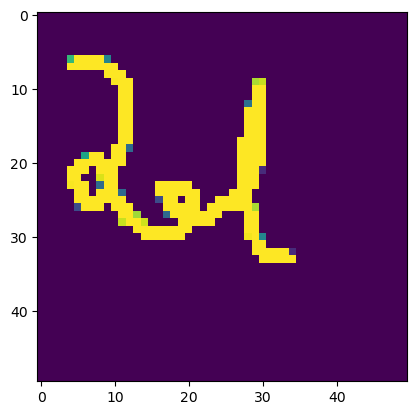

In [31]:
plt.figure()
plt.imshow(imgs[0])
plt.grid(False)
plt.show()

In [32]:
imgs = np.expand_dims(imgs, -1)

In [33]:
labels, imgs = shuffle(labels, imgs)
split = .75

labels_train = labels[:int(len(labels) * split)]
labels_test = labels[int(len(labels) * split):]

imgs_train = imgs[:int(len(imgs) * split)]
imgs_test = imgs[int(len(imgs) * split):]

In [34]:
np.unique(labels_train).shape

(47,)

In [35]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Create an ImageDataGenerator for data augmentation
datagen = ImageDataGenerator(
    rotation_range=10,
    width_shift_range=0.1,
    height_shift_range=0.1,
    zoom_range=0.1,
    shear_range=0.1,
    fill_mode='nearest'
)




In [36]:
batch_size = 16
epochs = 20

model = keras.Sequential([
    keras.Input(shape=(50, 50, 1)),
    layers.Conv2D(256, kernel_size=5, activation='relu'),
    layers.MaxPooling2D(pool_size=2),
    layers.Dropout(0.3),
    layers.Conv2D(512, kernel_size=5, activation='relu'),
    layers.MaxPooling2D(pool_size=2),
    layers.Dropout(0.3),
    layers.Conv2D(1024, kernel_size=5, activation='relu'),
    layers.MaxPooling2D(pool_size=2),
    layers.Dropout(0.3),
    layers.Flatten(),
    layers.Dense(len(ENCODER)+1, activation='softmax')
])

In [45]:
early_stopping = keras.callbacks.EarlyStopping(monitor="val_accuracy", patience=5)
optimizer = keras.optimizers.Adam()
reduce_lr = keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=2, min_lr=1e-6)

model.compile(loss='sparse_categorical_crossentropy',
              optimizer=optimizer,
              metrics=['accuracy'])

In [46]:
model.fit(datagen.flow(imgs_train,labels_train,batch_size=batch_size),
          epochs=epochs,
        
          validation_data=(imgs_test, labels_test),
          callbacks=[early_stopping, reduce_lr])

Epoch 1/20


C:\Users\Hp\AppData\Roaming\Python\Python312\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


35/35 ━━━━━━━━━━━━━━━━━━━━ 74s 2s/step - accuracy: 0.7990 - loss: 0.5811 - val_accuracy: 0.7869 - val_loss: 0.6838 - learning_rate: 0.0010
Epoch 2/20
35/35 ━━━━━━━━━━━━━━━━━━━━ 66s 2s/step - accuracy: 0.8387 - loss: 0.4699 - val_accuracy: 0.8251 - val_loss: 0.4955 - learning_rate: 0.0010
Epoch 3/20
35/35 ━━━━━━━━━━━━━━━━━━━━ 83s 2s/step - accuracy: 0.8523 - loss: 0.4289 - val_accuracy: 0.8361 - val_loss: 0.5561 - learning_rate: 0.0010
Epoch 4/20
35/35 ━━━━━━━━━━━━━━━━━━━━ 64s 2s/step - accuracy: 0.8424 - loss: 0.4940 - val_accuracy: 0.8634 - val_loss: 0.4813 - learning_rate: 0.0010
Epoch 5/20
35/35 ━━━━━━━━━━━━━━━━━━━━ 72s 2s/step - accuracy: 0.8302 - loss: 0.4547 - val_accuracy: 0.8689 - val_loss: 0.5110 - learning_rate: 0.0010
Epoch 6/20
35/35 ━━━━━━━━━━━━━━━━━━━━ 63s 2s/step - accuracy: 0.8890 - loss: 0.3312 - val_accuracy: 0.8634 - val_loss: 0.5323 - learning_rate: 0.0010
Epoch 7/20
35/35 ━━━━━━━━━━━━━━━━━━━━ 60s 2s/step - accuracy: 0.9036 - loss: 0.3499 - val_accuracy: 0.8907 - va

In [47]:
labels_pred = np.argmax(model.predict(imgs_test), axis=-1)

6/6 ━━━━━━━━━━━━━━━━━━━━ 4s 582ms/step


In [48]:
cm = confusion_matrix(labels_test, labels_pred, labels=list(ENCODER.inverse.keys()))

C:\ProgramData\anaconda3\Lib\site-packages\seaborn\utils.py:61: UserWarning: Glyph 2693 (\N{GUJARATI LETTER A}) missing from current font.
  fig.canvas.draw()
C:\ProgramData\anaconda3\Lib\site-packages\seaborn\utils.py:61: UserWarning: Matplotlib currently does not support Gujarati natively.
  fig.canvas.draw()
C:\ProgramData\anaconda3\Lib\site-packages\seaborn\utils.py:61: UserWarning: Glyph 2694 (\N{GUJARATI LETTER AA}) missing from current font.
  fig.canvas.draw()
C:\ProgramData\anaconda3\Lib\site-packages\seaborn\utils.py:61: UserWarning: Glyph 2695 (\N{GUJARATI LETTER I}) missing from current font.
  fig.canvas.draw()
C:\ProgramData\anaconda3\Lib\site-packages\seaborn\utils.py:61: UserWarning: Glyph 2696 (\N{GUJARATI LETTER II}) missing from current font.
  fig.canvas.draw()
C:\ProgramData\anaconda3\Lib\site-packages\seaborn\utils.py:61: UserWarning: Glyph 2697 (\N{GUJARATI LETTER U}) missing from current font.
  fig.canvas.draw()
C:\ProgramData\anaconda3\Lib\site-packages\seabor

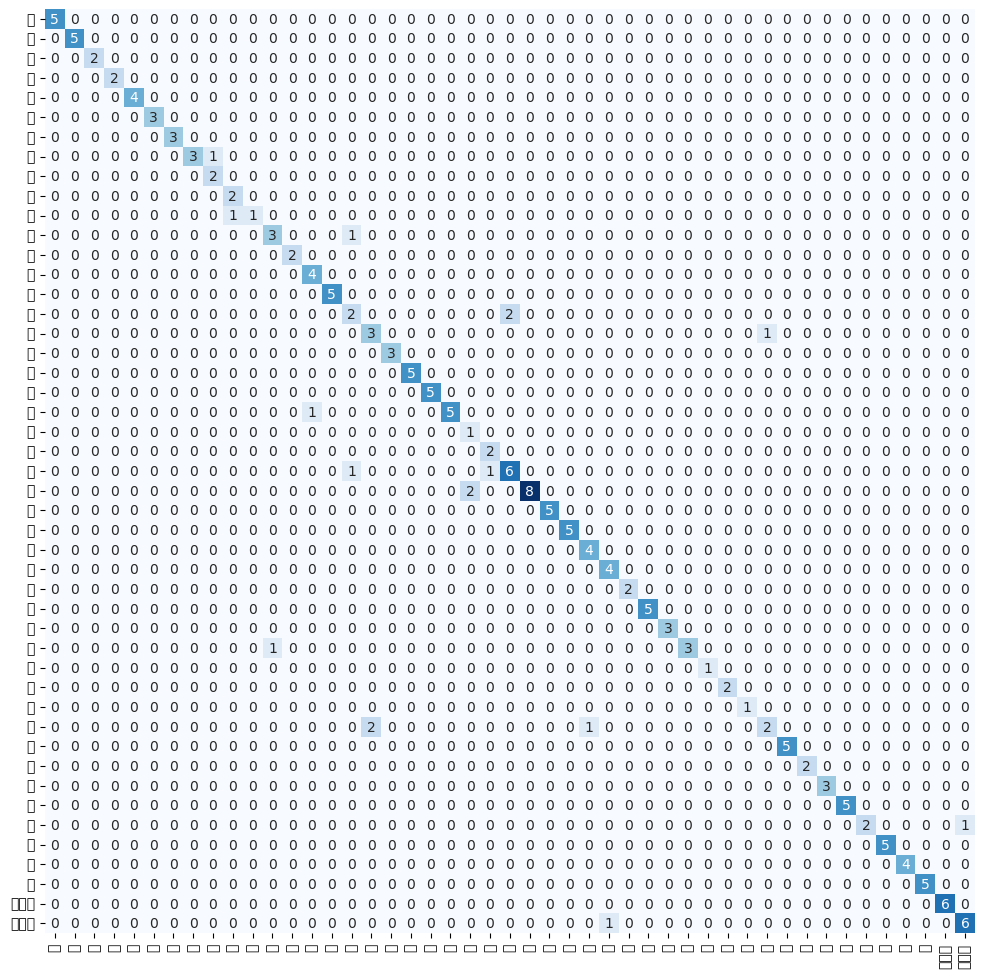

In [49]:
plt.figure(figsize=(12, 12))
sns.heatmap(cm, annot=True, cbar=False, cmap="Blues", xticklabels=list(ENCODER.keys()), yticklabels=list(ENCODER.keys()))
plt.show()

In [50]:
model.save('model.keras')